## TASK 4: PREPARE THE PROPOSALS FOR TRAINING

Summary of procedure:

- Iterate through all images and their annotations.

- Calculate the IoU for each proposal and assign the corresponding label.

- Store the information about proposals and labels in a format useful for training.

- Save the prepared data for use in the object detection model.

In [1]:

import os
import cv2
import selectivesearch
import sys

sys.path.append("..")  # Go up one level, adjust as necessary

from module.utils import  (
    parse_xml, 
    prepare_proposals, 
    get_proposals, 
    calculate_iou, 
    load_image, 
    get_id,
    calc_recall, 
    calc_abo,
    from_xywh_to_min_max,
    resize_box)
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
# Moving active directory to root folder to get module to work

In [2]:
img_path = "../Potholes/annotated-images/"
anno_path = "../Potholes/annotated-images/"
# This does not scale. We should save annotation proposals in a file. 

image_count = 100

We use the above function in a class for generating the Pothole images.

In [3]:


# proposal_data, labels = prepare_proposals(img_path, anno_path, 500, 0.5, image_count)



In [4]:
def visualize_image(image, boxes, proposals=None, scale_x=1.0, scale_y=1.0):
    # Adjust ground truth boxes according to the scale
    adjusted_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in boxes]
    
    # Convert color for display
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in adjusted_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw Selective Search proposals in green if provided
    if proposals is not None:
        for (x, y, w, h) in proposals:
            x, y, w, h = int(x), int(y), int(w), int(h)

            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
            # cv2.putText(image, (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
files = os.listdir(img_path)


image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))


boxes = [parse_xml(anno_path + label_path) for label_path in label_paths[:image_count]]
images = [load_image(img_path + img) for img in image_paths[:image_count]]
image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)

# visualize_image(image, boxes=boxes, proposals=proposal_data[0])

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Define the range of k (scale), sigmas, and min_sizes for hyperparameter tuning
scales = [5]
sigmas = [0.6 ]
min_sizes = [500]  # Add your desired min_size values here

# Maximum number of images to process
MAX_IMAGES = 20

# Image dimensions
TARGET_WIDTH = 800
TARGET_HEIGHT = 800

# Initialize results dictionary to store metrics for each (k, sigma, min_size) combination
results = {}

# Get image and label paths
files = os.listdir(img_path)
image_paths = [file for file in files if file.endswith(".jpg")]
label_paths = [file for file in files if file.endswith(".xml")]

# Sort the file lists to ensure correct pairing
image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)

# Limit the number of images to process


num_images = MAX_IMAGES

# Loop over all combinations of k, sigma, and min_size
for scale in scales:
    for sigma in sigmas:
        for min_size in min_sizes:
            key = (scale, sigma, min_size)
            if key not in results:
                results[key] = {'num_proposals': 0, 'recall': [], 'abo': []}

            # Prepare proposals for the current k, sigma, and min_size
            proposal_data, labels = prepare_proposals(
                images_path=img_path,
                annotations_path=anno_path,
                proposals_per_image=5000,
                iou_threshold=0.5,
                scale=scale,  # Use 'k' instead of 'scale'
                sigma=sigma,
                min_size=300,
                image_shape=(TARGET_HEIGHT, TARGET_WIDTH),
                count=MAX_IMAGES
            )

            # Process each image to calculate recall and ABO
            for i in range(num_images):
                # Get the proposals and labels for this image
                proposals = proposal_data[i]  # List of proposals (x, y, w, h)

                # Get the corresponding image and annotation filenames
                img_name = os.path.join(img_path, image_paths[i])
                gt_name = os.path.join(anno_path, label_paths[i])

                image = cv2.imread(img_name)

                original_height, original_width = image.shape[:2]
                height_ratio = TARGET_HEIGHT / original_height
                width_ratio = TARGET_WIDTH / original_width

                # Load and resize ground truth boxes
                ground_truth_boxes = parse_xml(gt_name)  # Returns boxes in (xmin, ymin, xmax, ymax) format
                ground_truth_boxes = [
                    (
                        int(xmin * width_ratio),
                        int(ymin * height_ratio),
                        int(xmax * width_ratio),
                        int(ymax * height_ratio)
                    )
                    for (xmin, ymin, xmax, ymax) in ground_truth_boxes
                ]
                
                

                num_ground_truth_boxes = len(ground_truth_boxes)

                # Calculate ABO and recall
                abo = calc_abo(proposals, ground_truth_boxes)
                recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)

                # Update results
                results[key]['recall'].append(recall)
                results[key]['abo'].append(abo)
                results[key]['num_proposals'] += len(proposals)

            avg_recall = np.mean(results[key]['recall'])
            print(f"Processed k={scale}, sigma={sigma}, min_size={min_size} for {num_images} images, recall={avg_recall:.4f}")

# Calculate average recall, ABO, and the number of proposals for each (k, sigma, min_size) combination
average_recalls = {key: np.mean(results[key]['recall']) for key in results}
average_abos = {key: np.mean(results[key]['abo']) for key in results}
average_num_proposals = {key: results[key]['num_proposals'] / num_images for key in results}

# Print out the results
print("\nk\tSigma\tMin_Size\tAvg Proposals\tAvg Recall\tAvg ABO")
print("--------------------------------------------------------------")
for (k, sigma, min_size) in sorted(results.keys()):
    avg_props = average_num_proposals[(k, sigma, min_size)]
    avg_recall = average_recalls[(k, sigma, min_size)]
    avg_abo = average_abos[(k, sigma, min_size)]
    print(f"{k}\t{sigma}\t{min_size}\t\t{avg_props:.2f}\t\t{avg_recall:.2f}\t\t{avg_abo:.2f}")


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Processed k=5, sigma=0.6, min_size=500 for 20 images, recall=0.9733

k	Sigma	Min_Size	Avg Proposals	Avg Recall	Avg ABO
--------------------------------------------------------------
5	0.6	500		4179.50		0.97		0.82


In [14]:

img_name = os.path.join(img_path, image_paths[0])
gt_name = os.path.join(anno_path, label_paths[0])

image = cv2.imread(img_name)

original_height, original_width = image.shape[:2]
height_ratio = TARGET_HEIGHT / original_height
width_ratio = TARGET_WIDTH / original_width

# Load and resize ground truth boxes
original = parse_xml(gt_name)  # Returns boxes in (xmin, ymin, xmax, ymax) format
ground_truth_boxes = [
    (
        int(xmin * width_ratio),
        int(ymin * height_ratio),
        int(xmax * width_ratio),
        int(ymax * height_ratio)
    )
    for (xmin, ymin, xmax, ymax) in original
]
print(ground_truth_boxes)
ground_truth_boxes = [resize_box(box, (original_width,original_width), (TARGET_HEIGHT, TARGET_WIDTH)) for box in original]
print(ground_truth_boxes)

[(118, 133, 291, 210)]
[(118, 133, 291, 210)]


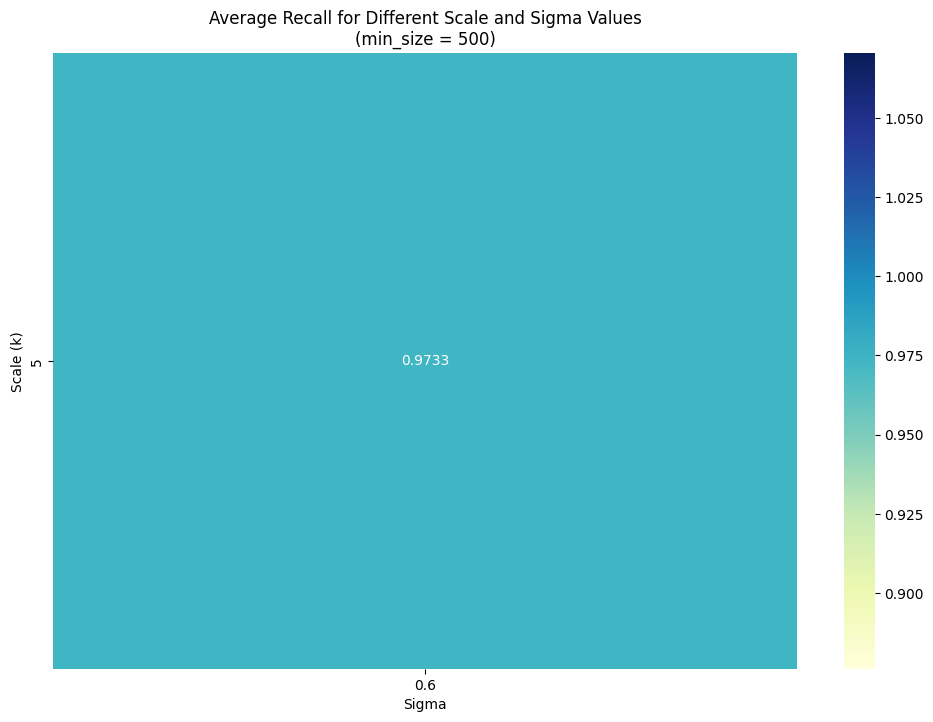

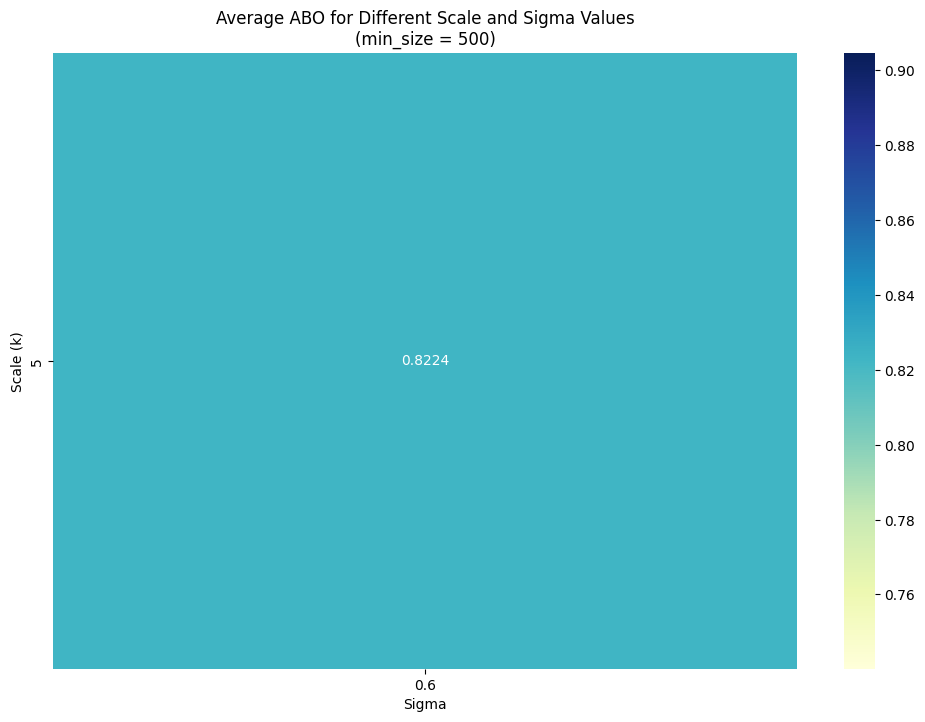

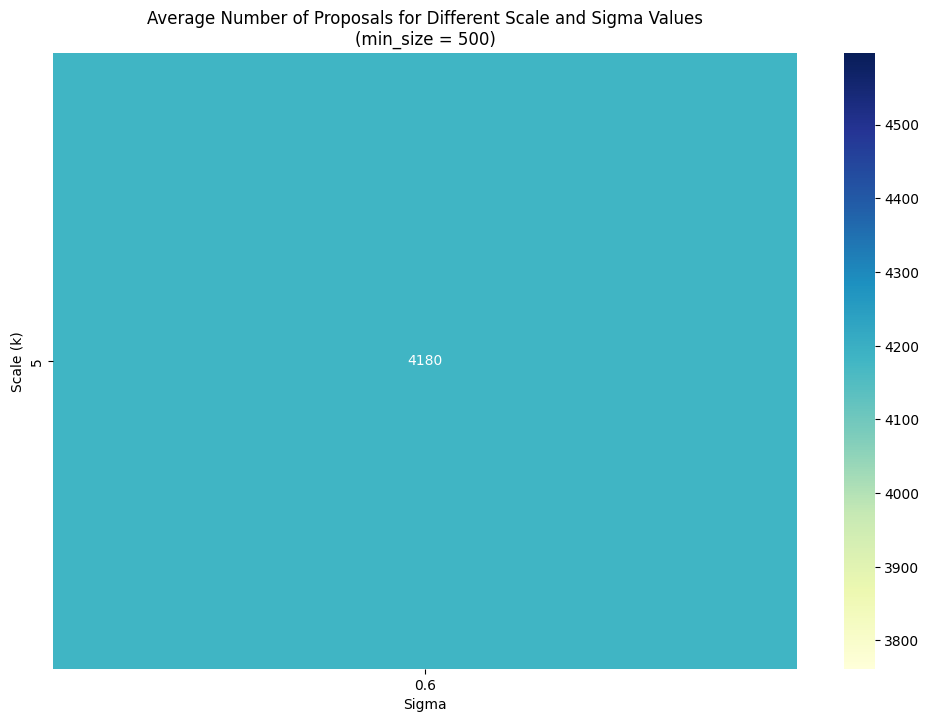

In [38]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for plotting or analysis
data = []
for (k, sigma, min_size) in results.keys():
    avg_props = average_num_proposals[(k, sigma, min_size)]
    avg_recall = average_recalls[(k, sigma, min_size)]
    avg_abo = average_abos[(k, sigma, min_size)]
    data.append({
        'Scale (k)': k,
        'Sigma': sigma,
        'Min_Size': min_size,
        'Avg Proposals': avg_props,
        'Avg Recall': avg_recall,
        'Avg ABO': avg_abo
    })

df = pd.DataFrame(data)

# Get the list of unique min_size values
min_size_values = df['Min_Size'].unique()

# Plot heatmaps for each min_size value
for min_size in min_size_values:
    # Filter the DataFrame for the current min_size
    df_min_size = df[df['Min_Size'] == min_size]
    
    # Pivot the DataFrame to create matrices for heatmaps
    recall_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg Recall')
    abo_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg ABO')
    proposals_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg Proposals')
    
    # Plot heatmap for Average Recall
    plt.figure(figsize=(12, 8))
    sns.heatmap(recall_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Average Recall for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()
    
    # Plot heatmap for Average ABO
    plt.figure(figsize=(12, 8))
    sns.heatmap(abo_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Average ABO for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()
    
    # Plot heatmap for Average Number of Proposals
    plt.figure(figsize=(12, 8))
    sns.heatmap(proposals_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f'Average Number of Proposals for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()


In [16]:
np.logspace(0,4, 40)

array([1.00000000e+00, 1.26638017e+00, 1.60371874e+00, 2.03091762e+00,
       2.57191381e+00, 3.25702066e+00, 4.12462638e+00, 5.22334507e+00,
       6.61474064e+00, 8.37677640e+00, 1.06081836e+01, 1.34339933e+01,
       1.70125428e+01, 2.15443469e+01, 2.72833338e+01, 3.45510729e+01,
       4.37547938e+01, 5.54102033e+01, 7.01703829e+01, 8.88623816e+01,
       1.12533558e+02, 1.42510267e+02, 1.80472177e+02, 2.28546386e+02,
       2.89426612e+02, 3.66524124e+02, 4.64158883e+02, 5.87801607e+02,
       7.44380301e+02, 9.42668455e+02, 1.19377664e+03, 1.51177507e+03,
       1.91448198e+03, 2.42446202e+03, 3.07029063e+03, 3.88815518e+03,
       4.92388263e+03, 6.23550734e+03, 7.89652287e+03, 1.00000000e+04])

In [16]:

space = np.linspace(10, 1500, 30)

# convert space to int
space = space.astype(int)


scale = 5
sigma = 0.6
min_size = 500
# Image dimensions
TARGET_WIDTH = 800
TARGET_HEIGHT = 800

IMAGE_SIZE = (TARGET_HEIGHT, TARGET_WIDTH)

num_images = 40
# Prepare proposals for the current k, sigma, and min_size
proposal_data, labels = prepare_proposals(
                images_path=img_path,
                annotations_path=anno_path,
                proposals_per_image=5000,
                iou_threshold=0.5,
                scale=scale,  # Use 'k' instead of 'scale'
                sigma=sigma,
                min_size=min_size,
                image_shape=(TARGET_HEIGHT, TARGET_WIDTH),
                count=num_images
            )




# Initialize dictionaries to store the sum of recall and abo for each count
recall_sum = {count: 0 for count in space}
abo_sum = {count: 0 for count in space}

# Initialize dictionaries to store the average recall and abo for each count
recall_avg = {count: 0 for count in space}
abo_avg = {count: 0 for count in space}

tmp_images = []
tmp_gt = []
# Process each image to calculate recall and ABO
for i in range(num_images):
    img_name = os.path.join(img_path, image_paths[i])
    gt_name = os.path.join(anno_path, label_paths[i])
    gt = parse_xml(gt_name)
    image = cv2.imread(img_name)
    
    tmp_gt.append(gt)
    tmp_images.append(image)
# Process each count
for count in space:
    for i in range(num_images):
        image = tmp_images[i]
        
        # Get the proposals and labels for this image
        proposals = proposal_data[i]  # List of proposals (x, y, w, h)
        # Get the corresponding image and annotation filenames
        img_name = os.path.join(img_path, image_paths[i])
        gt_name = os.path.join(anno_path, label_paths[i])
        
        original_height, original_width = image.shape[:2]
        height_ratio = TARGET_HEIGHT / original_height
        width_ratio = TARGET_WIDTH / original_width

        # Load and resize ground truth boxes
        ground_truth_boxes = tmp_gt[i]  # Returns boxes in (xmin, ymin, xmax, ymax) format
        ground_truth_boxes = [resize_box(box, (original_height,original_width), IMAGE_SIZE) for box in ground_truth_boxes]

        prop = proposals[:count]

        # Calculate ABO and recall
        abo = calc_abo(prop, ground_truth_boxes)
        recall = calc_recall(prop, ground_truth_boxes, iou_threshold=0.5)

        # Update the sum of recall and abo
        recall_sum[count] += recall
        abo_sum[count] += abo

    # Calculate the average recall and abo for the current count
    recall_avg[count] = recall_sum[count] / num_images
    abo_avg[count] = abo_sum[count] / num_images


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


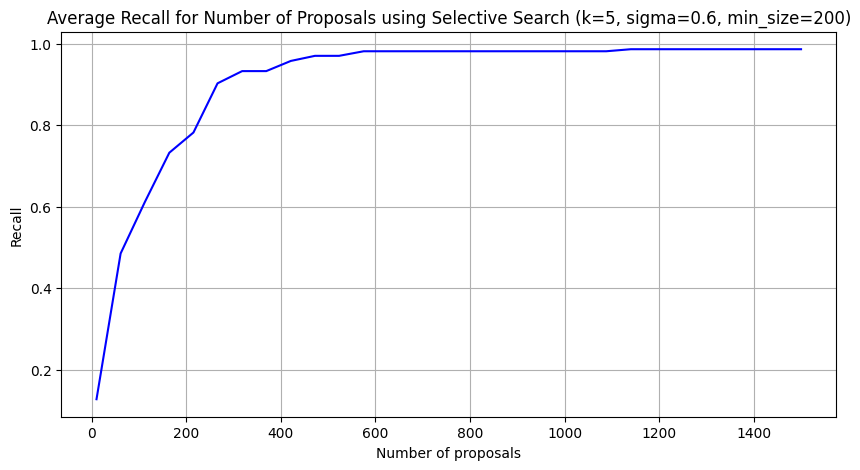

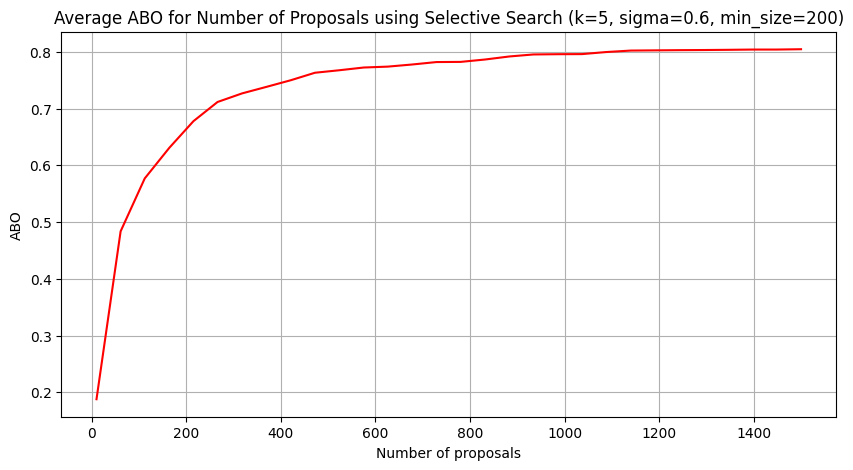

In [17]:
import matplotlib.pyplot as plt

# Plot for Recall
plt.figure(figsize=(10, 5))
plt.plot(space, list(recall_avg.values()), linestyle='-', color='b')
plt.title('Average Recall for Number of Proposals using Selective Search (k=5, sigma=0.6, min_size=200)')
plt.xlabel('Number of proposals')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Plot for ABO
plt.figure(figsize=(10, 5))
plt.plot(space, list(abo_avg.values()), linestyle='-', color='r')
plt.title('Average ABO for Number of Proposals using Selective Search (k=5, sigma=0.6, min_size=200)')
plt.xlabel('Number of proposals')
plt.ylabel('ABO')
plt.grid(True)
plt.show()

# Hyper parameter tuning without resizing

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Define the range of k (scale), sigmas, and min_sizes for hyperparameter tuning
scales = [5,15,30,50]
sigmas = [0.8,1.0,1.2 ]
min_sizes = [50,150,300]  # Add your desired min_size values here

# Maximum number of images to process
MAX_IMAGES = 40



# Initialize results dictionary to store metrics for each (k, sigma, min_size) combination
results = {}

# Get image and label paths
files = os.listdir(img_path)
image_paths = [file for file in files if file.endswith(".jpg")]
label_paths = [file for file in files if file.endswith(".xml")]

# Sort the file lists to ensure correct pairing
image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)

# Limit the number of images to process
if MAX_IMAGES is not None:
    image_paths = image_paths[:MAX_IMAGES]
    label_paths = label_paths[:MAX_IMAGES]

num_images = len(image_paths)

# Loop over all combinations of k, sigma, and min_size
for scale in scales:
    for sigma in sigmas:
        for min_size in min_sizes:
            key = (scale, sigma, min_size)
            if key not in results:
                results[key] = {'num_proposals': 0, 'recall': [], 'abo': []}

            # Prepare proposals for the current k, sigma, and min_size
            proposal_data, labels = prepare_proposals(
                images_path=img_path,
                annotations_path=anno_path,
                proposals_per_image=300,
                iou_threshold=0.5,
                scale=scale,  # Use 'k' instead of 'scale'
                sigma=sigma,
                min_size=min_size,
                image_shape=None,
                count=MAX_IMAGES
            )

            # Process each image to calculate recall and ABO
            for i in range(num_images):
                # Get the proposals and labels for this image
                proposals = proposal_data[i]  # List of proposals (x, y, w, h)

                # Get the corresponding image and annotation filenames
                img_name = os.path.join(img_path, image_paths[i])
                gt_name = os.path.join(anno_path, label_paths[i])

                image = cv2.imread(img_name)

                

                # Load and resize ground truth boxes
                ground_truth_boxes = parse_xml(gt_name)  # Returns boxes in (xmin, ymin, xmax, ymax) format                

                num_ground_truth_boxes = len(ground_truth_boxes)

                # Calculate ABO and recall
                abo = calc_abo(proposals, ground_truth_boxes)
                recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)

                # Update results
                results[key]['recall'].append(recall)
                results[key]['abo'].append(abo)
                results[key]['num_proposals'] += len(proposals)

            avg_recall = np.mean(results[key]['recall'])
            avg_abo = np.mean(results[key]['abo'])
            avg_proposal_count = np.mean(results[key]['num_proposals']) 
            print(f"Processed k={scale}, sigma={sigma}, min_size={min_size} for {num_images} images, recall={avg_recall:.4f}, abo={avg_abo:.4f}, proposals={avg_proposal_count:.2f}")

# Calculate average recall, ABO, and the number of proposals for each (k, sigma, min_size) combination
average_recalls = {key: np.mean(results[key]['recall']) for key in results}
average_abos = {key: np.mean(results[key]['abo']) for key in results}
average_num_proposals = {key: results[key]['num_proposals'] / num_images for key in results}

# Print out the results
print("\nk\tSigma\tMin_Size\tAvg Proposals\tAvg Recall\tAvg ABO")
print("--------------------------------------------------------------")
for (k, sigma, min_size) in sorted(results.keys()):
    avg_props = average_num_proposals[(k, sigma, min_size)]
    avg_recall = average_recalls[(k, sigma, min_size)]
    avg_abo = average_abos[(k, sigma, min_size)]
    print(f"{k}\t{sigma}\t{min_size}\t\t{avg_props:.2f}\t\t{avg_recall:.2f}\t\t{avg_abo:.2f}")


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Processed k=5, sigma=0.8, min_size=50 for 40 images, recall=0.9071, abo=0.6905, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Processed k=5, sigma=0.8, min_size=150 for 40 images, recall=0.9037, abo=0.7210, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


Processed k=5, sigma=0.8, min_size=300 for 40 images, recall=0.8400, abo=0.6970, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


Processed k=5, sigma=1.0, min_size=50 for 40 images, recall=0.8796, abo=0.6771, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Processed k=5, sigma=1.0, min_size=150 for 40 images, recall=0.9046, abo=0.7199, proposals=12000.00


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


Processed k=5, sigma=1.0, min_size=300 for 40 images, recall=0.8650, abo=0.7092, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


Processed k=5, sigma=1.2, min_size=50 for 40 images, recall=0.8775, abo=0.7085, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


Processed k=5, sigma=1.2, min_size=150 for 40 images, recall=0.8250, abo=0.6842, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Processed k=5, sigma=1.2, min_size=300 for 40 images, recall=0.8542, abo=0.7059, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Processed k=15, sigma=0.8, min_size=50 for 40 images, recall=0.9254, abo=0.7062, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


Processed k=15, sigma=0.8, min_size=150 for 40 images, recall=0.9108, abo=0.7366, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.43it/s]


Processed k=15, sigma=0.8, min_size=300 for 40 images, recall=0.8804, abo=0.6997, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


Processed k=15, sigma=1.0, min_size=50 for 40 images, recall=0.9092, abo=0.7383, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


Processed k=15, sigma=1.0, min_size=150 for 40 images, recall=0.8817, abo=0.6942, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.43it/s]


Processed k=15, sigma=1.0, min_size=300 for 40 images, recall=0.8892, abo=0.6898, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


Processed k=15, sigma=1.2, min_size=50 for 40 images, recall=0.9512, abo=0.7252, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Processed k=15, sigma=1.2, min_size=150 for 40 images, recall=0.8779, abo=0.7023, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


Processed k=15, sigma=1.2, min_size=300 for 40 images, recall=0.8925, abo=0.7202, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


Processed k=30, sigma=0.8, min_size=50 for 40 images, recall=0.9142, abo=0.7219, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


Processed k=30, sigma=0.8, min_size=150 for 40 images, recall=0.9496, abo=0.7142, proposals=12000.00


100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


Processed k=30, sigma=0.8, min_size=300 for 40 images, recall=0.8883, abo=0.6793, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Processed k=30, sigma=1.0, min_size=50 for 40 images, recall=0.8592, abo=0.7093, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


Processed k=30, sigma=1.0, min_size=150 for 40 images, recall=0.8654, abo=0.7081, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


Processed k=30, sigma=1.0, min_size=300 for 40 images, recall=0.9179, abo=0.7124, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Processed k=30, sigma=1.2, min_size=50 for 40 images, recall=0.8538, abo=0.6994, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


Processed k=30, sigma=1.2, min_size=150 for 40 images, recall=0.9092, abo=0.6882, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Processed k=30, sigma=1.2, min_size=300 for 40 images, recall=0.9242, abo=0.7082, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


Processed k=50, sigma=0.8, min_size=50 for 40 images, recall=0.8704, abo=0.7012, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Processed k=50, sigma=0.8, min_size=150 for 40 images, recall=0.8562, abo=0.7059, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.48it/s]


Processed k=50, sigma=0.8, min_size=300 for 40 images, recall=0.8263, abo=0.6834, proposals=12000.00


100%|██████████| 40/40 [00:26<00:00,  1.49it/s]


Processed k=50, sigma=1.0, min_size=50 for 40 images, recall=0.8458, abo=0.6918, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


Processed k=50, sigma=1.0, min_size=150 for 40 images, recall=0.8933, abo=0.6948, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


Processed k=50, sigma=1.0, min_size=300 for 40 images, recall=0.9338, abo=0.7178, proposals=12000.00


100%|██████████| 40/40 [00:27<00:00,  1.48it/s]


Processed k=50, sigma=1.2, min_size=50 for 40 images, recall=0.8783, abo=0.6729, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


Processed k=50, sigma=1.2, min_size=150 for 40 images, recall=0.8529, abo=0.7007, proposals=12000.00


100%|██████████| 40/40 [00:28<00:00,  1.43it/s]


Processed k=50, sigma=1.2, min_size=300 for 40 images, recall=0.8529, abo=0.7008, proposals=12000.00

k	Sigma	Min_Size	Avg Proposals	Avg Recall	Avg ABO
--------------------------------------------------------------
5	0.8	50		300.00		0.91		0.69
5	0.8	150		300.00		0.90		0.72
5	0.8	300		300.00		0.84		0.70
5	1.0	50		300.00		0.88		0.68
5	1.0	150		300.00		0.90		0.72
5	1.0	300		300.00		0.86		0.71
5	1.2	50		300.00		0.88		0.71
5	1.2	150		300.00		0.82		0.68
5	1.2	300		300.00		0.85		0.71
15	0.8	50		300.00		0.93		0.71
15	0.8	150		300.00		0.91		0.74
15	0.8	300		300.00		0.88		0.70
15	1.0	50		300.00		0.91		0.74
15	1.0	150		300.00		0.88		0.69
15	1.0	300		300.00		0.89		0.69
15	1.2	50		300.00		0.95		0.73
15	1.2	150		300.00		0.88		0.70
15	1.2	300		300.00		0.89		0.72
30	0.8	50		300.00		0.91		0.72
30	0.8	150		300.00		0.95		0.71
30	0.8	300		300.00		0.89		0.68
30	1.0	50		300.00		0.86		0.71
30	1.0	150		300.00		0.87		0.71
30	1.0	300		300.00		0.92		0.71
30	1.2	50		300.00		0.85		0.70
30	1.2	150		300.00		0.91		0.

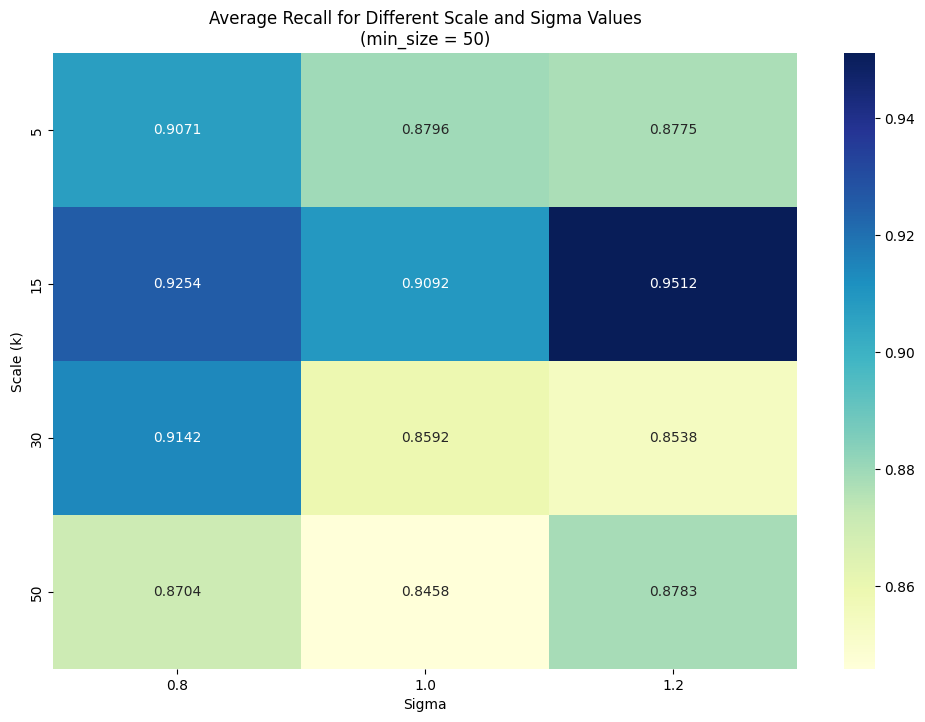

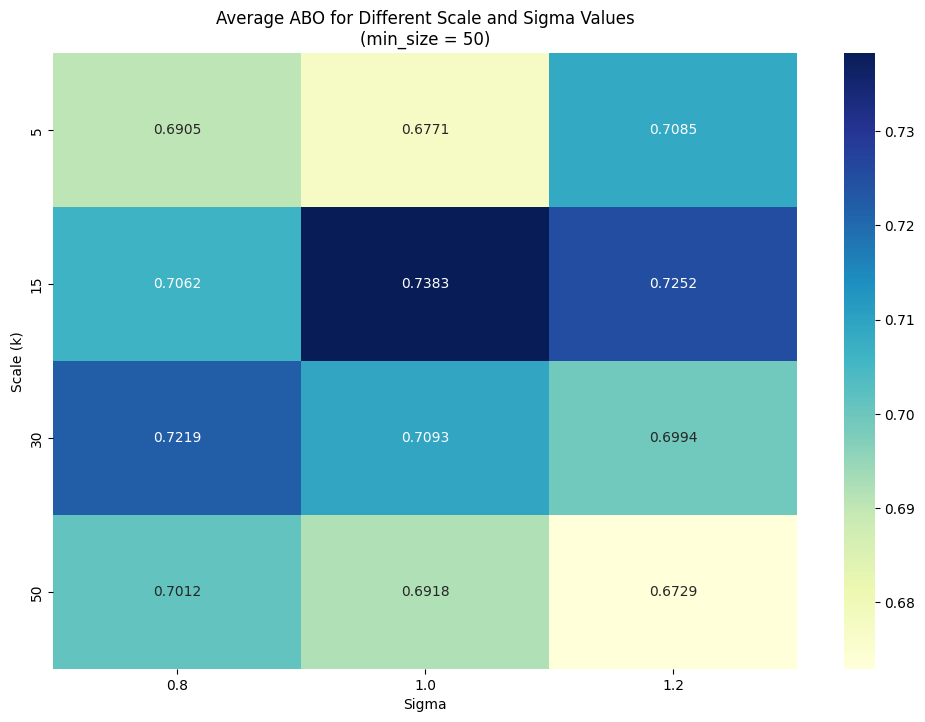

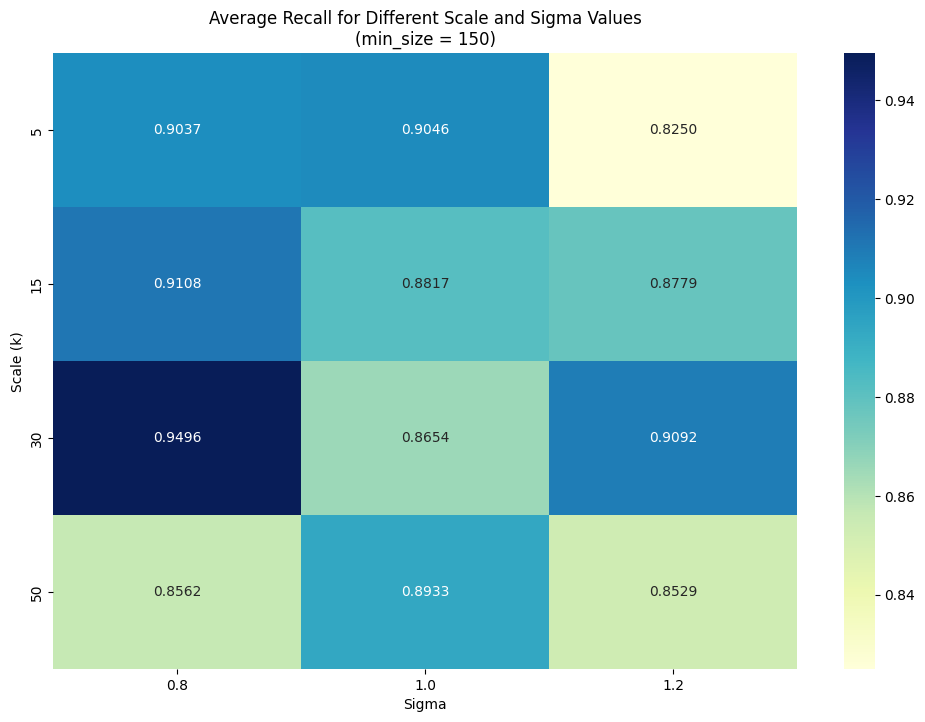

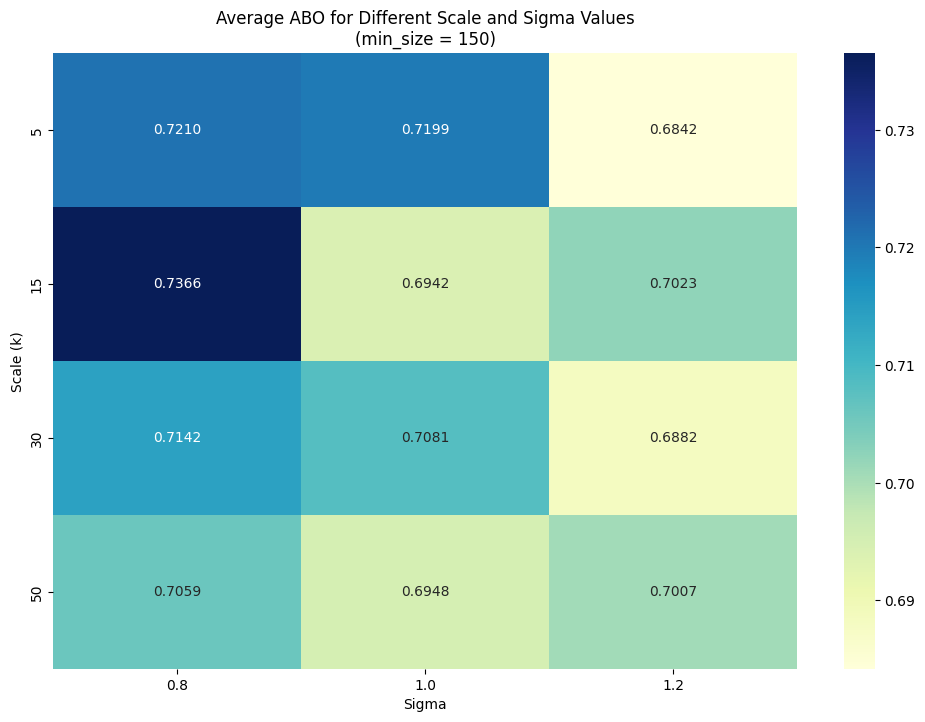

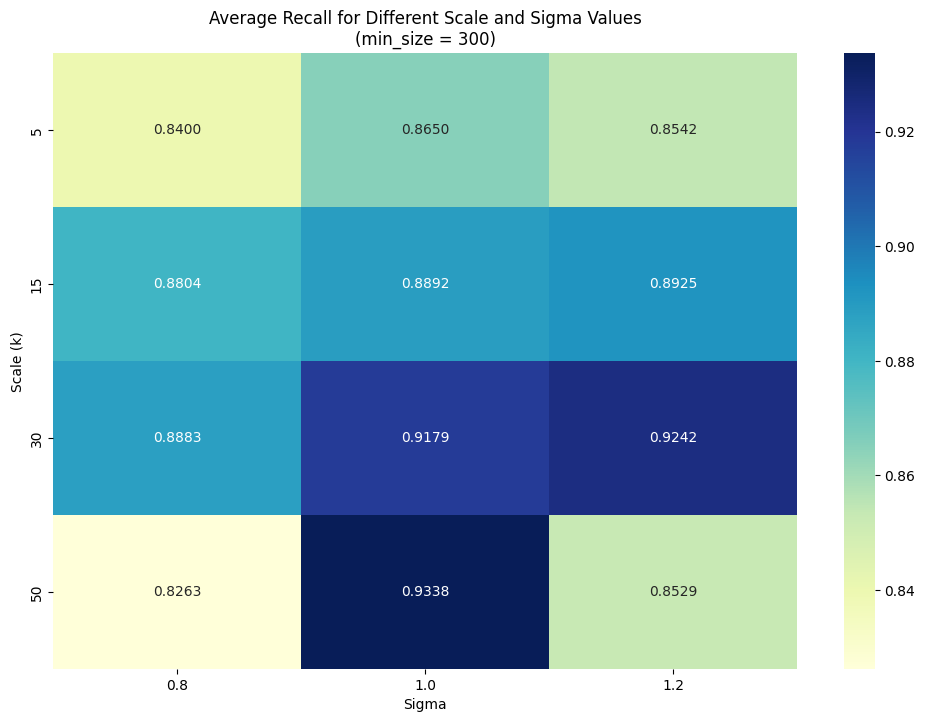

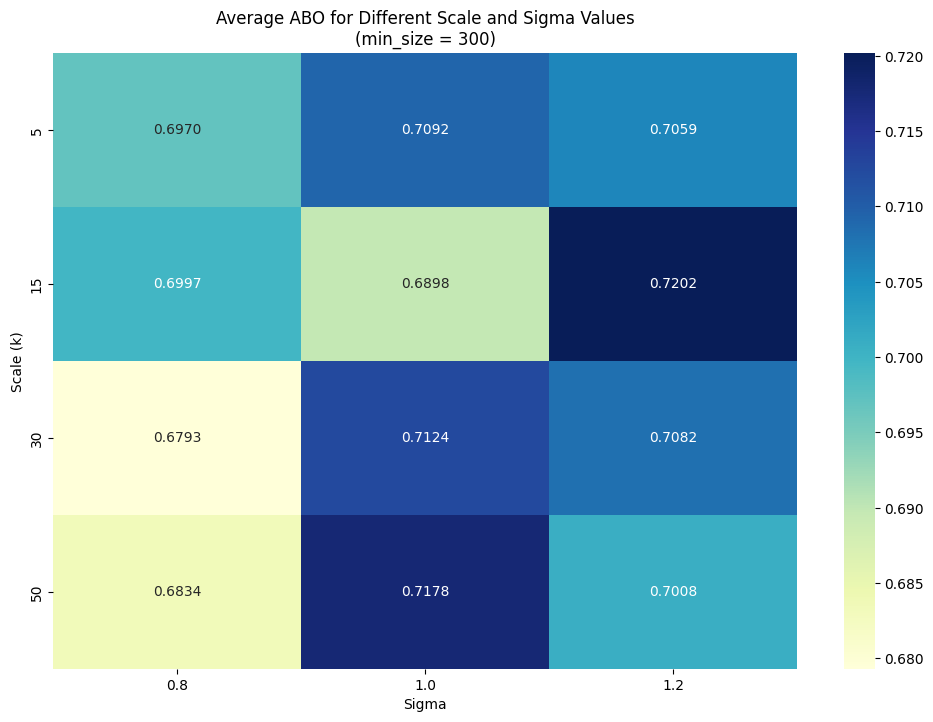

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for plotting or analysis
data = []
for (k, sigma, min_size) in results.keys():
    avg_props = average_num_proposals[(k, sigma, min_size)]
    avg_recall = average_recalls[(k, sigma, min_size)]
    avg_abo = average_abos[(k, sigma, min_size)]
    data.append({
        'Scale (k)': k,
        'Sigma': sigma,
        'Min_Size': min_size,
        'Avg Proposals': avg_props,
        'Avg Recall': avg_recall,
        'Avg ABO': avg_abo
    })

df = pd.DataFrame(data)

# Get the list of unique min_size values
min_size_values = df['Min_Size'].unique()

# Plot heatmaps for each min_size value
for min_size in min_size_values:
    # Filter the DataFrame for the current min_size
    df_min_size = df[df['Min_Size'] == min_size]
    
    # Pivot the DataFrame to create matrices for heatmaps
    recall_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg Recall')
    abo_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg ABO')
    proposals_pivot = df_min_size.pivot(index='Scale (k)', columns='Sigma', values='Avg Proposals')
    
    # Plot heatmap for Average Recall
    plt.figure(figsize=(12, 8))
    sns.heatmap(recall_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Average Recall for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()
    
    # Plot heatmap for Average ABO
    plt.figure(figsize=(12, 8))
    sns.heatmap(abo_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Average ABO for Different Scale and Sigma Values\n(min_size = {min_size})')
    plt.xlabel('Sigma')
    plt.ylabel('Scale (k)')
    plt.show()



In [6]:

space = np.linspace(10, 1500, 30)

# convert space to int
space = space.astype(int)


scale = 5
sigma = 1.2
min_size = 200

num_images = 40
# Prepare proposals for the current k, sigma, and min_size
proposal_data, labels = prepare_proposals(
                images_path=img_path,
                annotations_path=anno_path,
                proposals_per_image=5000,
                iou_threshold=0.5,
                scale=scale,  # Use 'k' instead of 'scale'
                sigma=sigma,
                min_size=min_size,
                image_shape=None,
                count=num_images
            )




# Initialize dictionaries to store the sum of recall and abo for each count
recall_sum = {count: 0 for count in space}
abo_sum = {count: 0 for count in space}

# Initialize dictionaries to store the average recall and abo for each count
recall_avg = {count: 0 for count in space}
abo_avg = {count: 0 for count in space}

tmp_images = []
tmp_gt = []

# Process each image to calculate recall and ABO
for i in range(num_images):
    img_name = os.path.join(img_path, image_paths[i])
    gt_name = os.path.join(anno_path, label_paths[i])
    gt = parse_xml(gt_name)
    image = cv2.imread(img_name)
    
    tmp_gt.append(gt)
    tmp_images.append(image)
# Process each count
for count in space:
    for i in range(num_images):
        image = tmp_images[i]
        
        # Get the proposals and labels for this image
        proposals = proposal_data[i]  # List of proposals (x, y, w, h)
        # Get the corresponding image and annotation filenames

        

        # Load and resize ground truth boxes
        ground_truth_boxes = tmp_gt[i]  # Returns boxes in (xmin, ymin, xmax, ymax) format

        prop = proposals[:count]

        # Calculate ABO and recall
        abo = calc_abo(prop, ground_truth_boxes)
        recall = calc_recall(prop, ground_truth_boxes, iou_threshold=0.5)

        # Update the sum of recall and abo
        recall_sum[count] += recall
        abo_sum[count] += abo

    # Calculate the average recall and abo for the current count
    recall_avg[count] = recall_sum[count] / num_images
    abo_avg[count] = abo_sum[count] / num_images


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


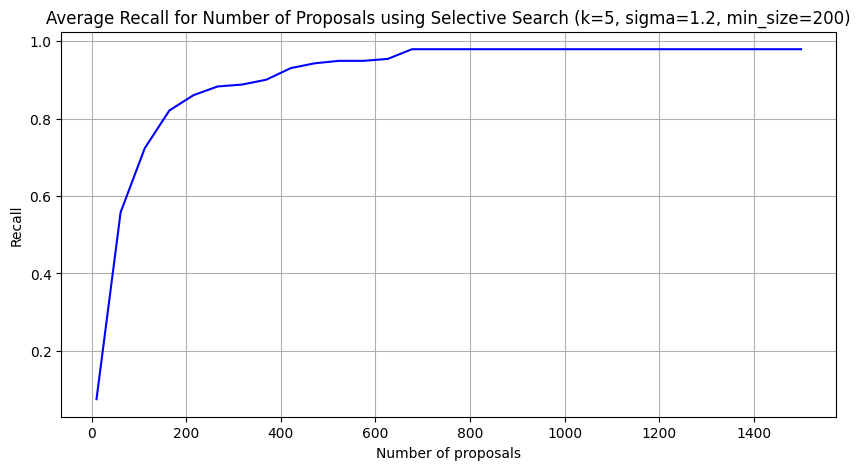

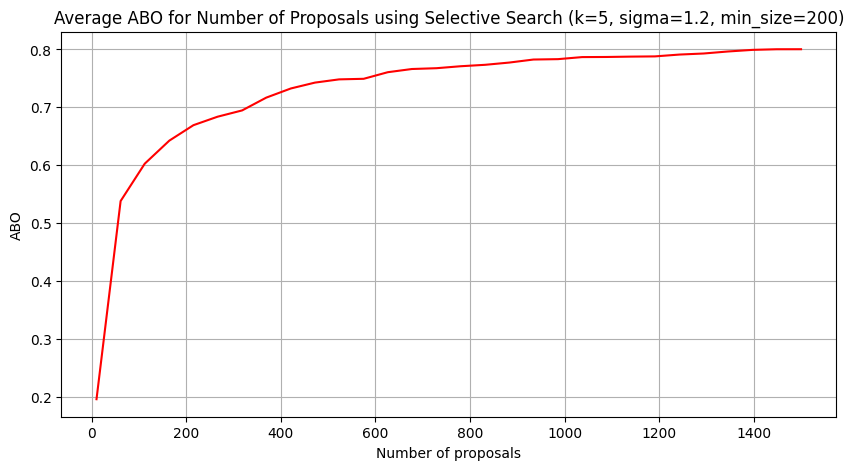

In [7]:
import matplotlib.pyplot as plt

# Plot for Recall
plt.figure(figsize=(10, 5))
plt.plot(space, list(recall_avg.values()), linestyle='-', color='b')
plt.title('Average Recall for Number of Proposals using Selective Search (k=5, sigma=1.2, min_size=200)')
plt.xlabel('Number of proposals')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# Plot for ABO
plt.figure(figsize=(10, 5))
plt.plot(space, list(abo_avg.values()), linestyle='-', color='r')
plt.title('Average ABO for Number of Proposals using Selective Search (k=5, sigma=1.2, min_size=200)')
plt.xlabel('Number of proposals')
plt.ylabel('ABO')
plt.grid(True)
plt.show()